## Table of Contents

- [Introduction](#intro)
- [Libraries](#lib)
- [Load Data](#load)
- [Feature Engineering](#feat)
- [Identifying Optimum number of Clusters](#num)
- [Simple KMeans](#kmeans)
- [PCA](#pca)
- [KMeans with PCA](#kpca)
- [t-SNE](#tsne)
- [KMeans with t-SNE](#ktsne)
- [Mini-Batch KMeans Clustering](#mini)
- [Agglomerative Clustering](#agglo)
- [DBSCAN](#dbscan)
- [OPTICS](#optics)
- [Birch](#birch)
- [Cluster Evaluation](#eval)

## Introduction
<a id= "intro" > </a>

**Objective:**
- Learning various Clustering Techniques
- Apply Dimensionality Reduction to account for the Curse of Dimensionality
- Evaluate the clusters to make business sense out of them

## Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arketing-campaign/marketing_campaign.csv
/kaggle/input/arketing-campaign/marketing_campaign.xlsx


<a id= "lib" > </a>

In [2]:
#!pip install openpyxl

In [3]:
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, \
Birch, DBSCAN, MiniBatchKMeans, MeanShift, OPTICS, SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

## Functions & Constants

In [4]:
# One Hot Encoder to encode Categorical Variables
def one_hot_encoder(dataframe, encoding_col_list):
    ohe= OneHotEncoder()
    dummies = ohe.fit_transform(dataframe[encoding_col_list]).toarray()
    feature_names = ohe.get_feature_names_out(encoding_col_list)
    dummies_df = pd.DataFrame(dummies,columns=feature_names).astype(int)

    dataframe_enc = pd.concat([dataframe, dummies_df], axis=1, join='inner')

    dataframe_enc.drop(encoding_col_list,axis=1, inplace=True)
    return dataframe_enc

# Elbow method to determne the optimum number of Clusters
def elbow(dataframe, l_range, h_range):
    distortions = []
    for i in range(l_range, h_range):
        km = KMeans(
            n_clusters=i, init='k-means++',
            n_init=10, max_iter=100, random_state=0
        )
        km.fit(dataframe)
        distortions.append(km.inertia_)

    # plot
    plt.plot(range(l_range, h_range), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
    
    
#Elbow Method with Yellowbrick Library
def elbow_auto(dataframe):
    model = KMeans(init='k-means++',
                n_init=10, max_iter=100, random_state=0)
    visualizer = KElbowVisualizer(model, k=10)

    visualizer.fit(dataframe)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure
    
    
#Using Silhoutte Score to determine the optimum number of Clusters
def silhoutte(dataframe, l_range, h_range):
    for i in range(l_range, h_range):
        km = KMeans(
            n_clusters=i, init='k-means++',
            n_init=10, max_iter=100, random_state=0
        )
        km.fit(dataframe)
        cluster_labels = km.labels_

        silhouette_avg = silhouette_score(dataframe, cluster_labels)
        print(f" For {i} clusters, SilhoutteScore is: {silhouette_avg}")
        

#Silhoutte Score method using Yellwbrick library
def silhoutte_auto(dataframe, l_range, h_range):
    model = KMeans(init='k-means++',n_init=10, max_iter=100, random_state=0)
    visualizer = KElbowVisualizer(model, k=(l_range,h_range), metric='silhouette')

    visualizer.fit(dataframe)
    visualizer.show()
    plt.show()

<a id= "load" > </a>

## Load Data

In [5]:
df= pd.read_csv("../input/arketing-campaign/marketing_campaign.csv", delimiter= ";")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


## Data Description

In [6]:
print(len(df))
print(len(df.columns))

2240
29


In [7]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

## Missing Values

In [8]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [9]:
df.dropna(axis= 0, inplace=True)
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [10]:
df.nunique()

ID                     2216
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1974
Kidhome                   3
Teenhome                  3
Dt_Customer             662
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         554
MntFishProducts         182
MntSweetProducts        176
MntGoldProds            212
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

Z_CostContact and Z_Revenue have the same value for all data points which means these variables do not add any value to our analysis. So let us drop these

In [11]:
df.drop(["Z_CostContact", "Z_Revenue"], axis=1 , inplace=True)

In [12]:
plot_cols= [c for c in df.columns if df[c].nunique()<20]
plot_cols

['Education',
 'Marital_Status',
 'Kidhome',
 'Teenhome',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Response']

In [13]:
for c in plot_cols:
    fig= px.histogram(df, x=c, text_auto= True)
    fig.show()
    

<a id= "feat" > </a>

## Feature Engineering

In [14]:
#Convert date to date object
df["Dt_Customer"]= pd.to_datetime(df["Dt_Customer"])

#Create Month and Year variables from Dt_Customer
df["Customer_year"]= df["Dt_Customer"].dt.year
df["Customer_month"]= df["Dt_Customer"].dt.month

#Removing ID, Date from further analysis
df.drop(["ID","Dt_Customer"], axis= 1, inplace=True)
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_year,Customer_month
0,1957,Graduation,Single,58138.0,0,0,58,635,88,546,...,7,0,0,0,0,0,0,1,2012,9
1,1954,Graduation,Single,46344.0,1,1,38,11,1,6,...,5,0,0,0,0,0,0,0,2014,3
2,1965,Graduation,Together,71613.0,0,0,26,426,49,127,...,4,0,0,0,0,0,0,0,2013,8
3,1984,Graduation,Together,26646.0,1,0,26,11,4,20,...,6,0,0,0,0,0,0,0,2014,2
4,1981,PhD,Married,58293.0,1,0,94,173,43,118,...,5,0,0,0,0,0,0,0,2014,1


### Encoding Education, Marital Status to numerical format

Marital Status:<br>
Alone, Absured, YOLO can be combined with Single and then this column can be one-hot encoded

In [15]:
df["Marital_Status"].replace(["Alone","Absurd","YOLO"],'Single', inplace=True)
df_enc= df.copy()

In [16]:
#df_enc = one_hot_encoder(df, encoding_col_list= ["Education","Marital_Status"])
le= LabelEncoder()
enc_cols= ["Education","Marital_Status"]
for c in enc_cols:
    df_enc[c]= le.fit_transform(df_enc[c])

In [17]:
len(df_enc)

2216

In [18]:
df_enc.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_year,Customer_month
0,1957,2,2,58138.0,0,0,58,635,88,546,...,7,0,0,0,0,0,0,1,2012,9
1,1954,2,2,46344.0,1,1,38,11,1,6,...,5,0,0,0,0,0,0,0,2014,3
2,1965,2,3,71613.0,0,0,26,426,49,127,...,4,0,0,0,0,0,0,0,2013,8
3,1984,2,3,26646.0,1,0,26,11,4,20,...,6,0,0,0,0,0,0,0,2014,2
4,1981,4,1,58293.0,1,0,94,173,43,118,...,5,0,0,0,0,0,0,0,2014,1


### Feature Scaling

In [19]:
scaler= MinMaxScaler()
scaled = scaler.fit_transform(df_enc)
df_enc_scaled= pd.DataFrame(scaled, columns= df_enc.columns)
df_enc_scaled.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_year,Customer_month
0,0.621359,0.5,0.50,0.084832,0.0,0.0,0.585859,0.425318,0.442211,0.316522,...,0.35,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.727273
1,0.592233,0.5,0.50,0.067095,0.5,0.5,0.383838,0.007368,0.005025,0.003478,...,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.181818
2,0.699029,0.5,0.75,0.105097,0.0,0.0,0.262626,0.285332,0.246231,0.073623,...,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.636364
3,0.883495,0.5,0.75,0.037471,0.5,0.0,0.262626,0.007368,0.020101,0.011594,...,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.090909
4,0.854369,1.0,0.25,0.085065,0.5,0.0,0.949495,0.115874,0.216080,0.068406,...,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000


<a id= "num" > </a>

## Identifying the Number of Clusters

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. <br>
Distortion is calculated as the average of the squared distances (let’s say Euclidean distance) from the cluster centers of the respective clusters. Inertia represents the sum of squared distances of samples to their closest cluster center.

**Elbow Method**

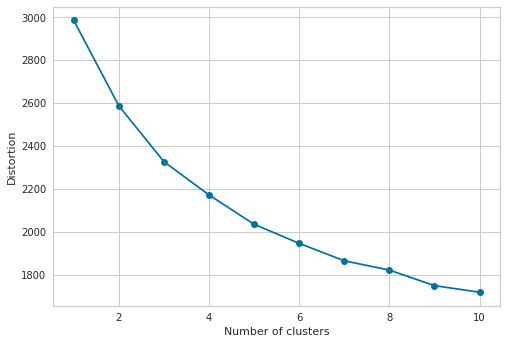

In [20]:
elbow(df_enc_scaled, 1, 11)

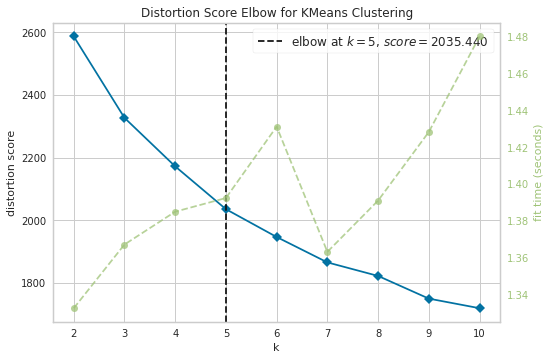

In [21]:
elbow_auto(df_enc_scaled)

Again this visualizer used distortion as a metric. It can be useful when we are not quite sure when our metric starts to be linear.

**Silhoutte Method**

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

This function returns the mean Silhouette Coefficient over all samples. To obtain the values for each sample, use silhouette_samples.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [22]:
silhoutte(df_enc_scaled, 2, 11)

 For 2 clusters, SilhoutteScore is: 0.15812261644558528
 For 3 clusters, SilhoutteScore is: 0.13993191359901228
 For 4 clusters, SilhoutteScore is: 0.0962602488286263
 For 5 clusters, SilhoutteScore is: 0.1127223016476362
 For 6 clusters, SilhoutteScore is: 0.10419850931772881
 For 7 clusters, SilhoutteScore is: 0.11252232962744121
 For 8 clusters, SilhoutteScore is: 0.10750543409312643
 For 9 clusters, SilhoutteScore is: 0.10826583345840919
 For 10 clusters, SilhoutteScore is: 0.11160934550106738


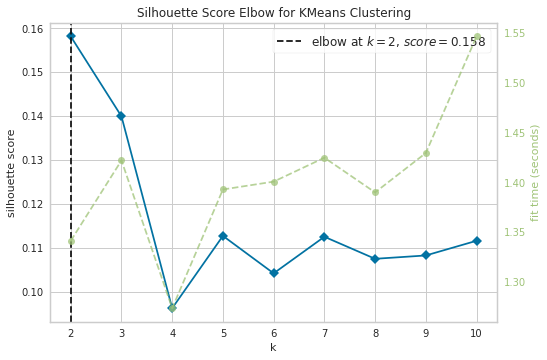

In [23]:
silhoutte_auto(df_enc_scaled, 2, 11)

For simplicity, we will use 3 Clusters

<a id= "kmeans" > </a>

## 1.1 K Means Clustering without Dimensionality Reduction

As k-means clustering aims to converge on an optimal set of cluster centers (centroids) and cluster membership based on distance from these centroids via successive iterations, it is intuitive that the more optimal the positioning of these initial centroids, the fewer iterations of the k-means clustering algorithms will be required for convergence. 
- random data points: In this approach, described in the "traditional" case above, k random data points are selected from the dataset and used as the initial centroids, an approach which is obviously highly volatile and provides for a scenario where the selected centroids are not well positioned throughout the entire data space.
- k-means++: As spreading out the initial centroids is thought to be a worthy goal, k-means++ pursues this by assigning the first centroid to the location of a randomly selected data point, and then choosing the subsequent centroids from the remaining data points based on a probability proportional to the squared distance away from a given point's nearest existing centroid. The effect is an attempt to push the centroids as far from one another as possible, covering as much of the occupied data space as they can from initialization.<br>
Source: https://www.kdnuggets.com/2020/06/centroid-initialization-k-means-clustering.html

- n_init: default=10 <br>
Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
- Method for initialization: ‘k-means++’ <br>
selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. <br>

In [24]:
km= KMeans(n_clusters=3, init='k-means++',
            n_init=10, max_iter=100, random_state=0)
km.fit(df_enc_scaled)
df["cluster_km_orig"] = km.labels_

In [25]:
# Silhoutte Score
sc= silhouette_score(df_enc_scaled, km.labels_)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.13993191359901228


<a id= "pca" > </a>

## Dimensionality Reduction: PCA

First, let’s determine what is the optimal number of principal components we need by examining the amount of variance each principal component encompasses.

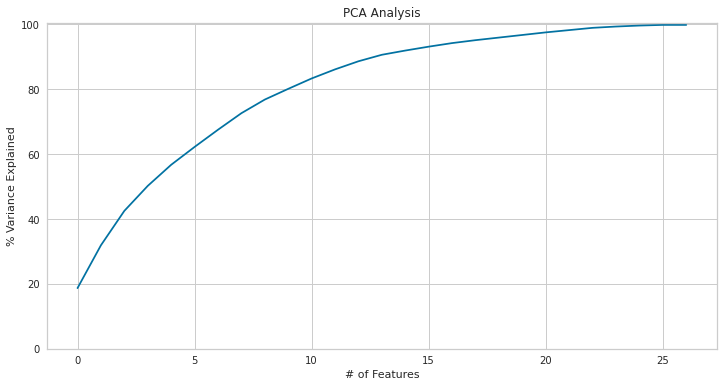

In [26]:
pca = PCA(n_components= len(df_enc_scaled.columns))
pca.fit(df_enc_scaled)
variance = pca.explained_variance_ratio_
var = np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(var)

In [27]:
var

array([18.7, 31.9, 42.5, 50.2, 56.7, 62.2, 67.5, 72.6, 76.8, 80.1, 83.3,
       86.1, 88.6, 90.6, 91.9, 93.1, 94.2, 95.1, 95.9, 96.7, 97.5, 98.2,
       98.9, 99.3, 99.6, 99.8, 99.8])

In [28]:
pca = PCA(n_components=3)
pca.fit(df_enc_scaled)
PCA_df = pd.DataFrame(pca.transform(df_enc_scaled), columns=(["col1","col2", "col3"]))
PCA_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2216.0,-5.410834e-17,0.502354,-0.844879,-0.410541,-0.084719,0.294506,1.762929
col2,2216.0,3.567143e-17,0.422248,-0.865228,-0.328655,0.006104,0.345695,1.044642
col3,2216.0,-4.889791e-17,0.378051,-0.792269,-0.281044,-0.032422,0.183799,1.328991


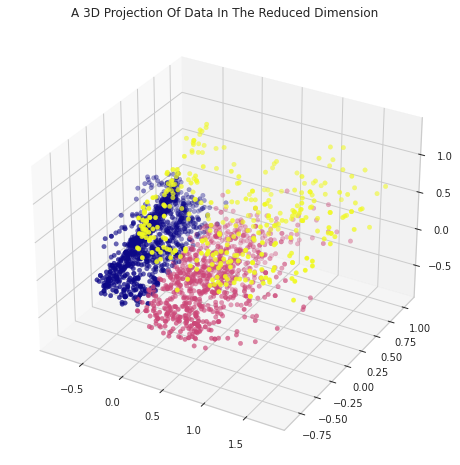

In [29]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_df["col1"]
y =PCA_df["col2"]
z =PCA_df["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c= km.labels_, marker="o" , cmap="plasma")
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

<a id= "kpca" > </a>

## 1.2 KMeans Clustering after PCA

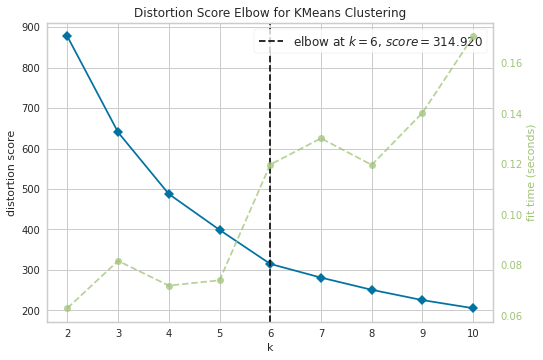

In [30]:
elbow_auto(PCA_df)

In [31]:
silhoutte(PCA_df,2,11)

 For 2 clusters, SilhoutteScore is: 0.32444266084351664
 For 3 clusters, SilhoutteScore is: 0.3466547336812418
 For 4 clusters, SilhoutteScore is: 0.3445619074181657
 For 5 clusters, SilhoutteScore is: 0.34493029065946934
 For 6 clusters, SilhoutteScore is: 0.372336348137769
 For 7 clusters, SilhoutteScore is: 0.37654220888274426
 For 8 clusters, SilhoutteScore is: 0.3456983188173913
 For 9 clusters, SilhoutteScore is: 0.35095152280043046
 For 10 clusters, SilhoutteScore is: 0.3581119089664426


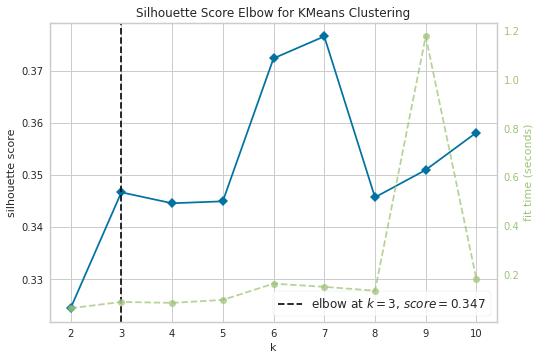

In [32]:
silhoutte_auto(PCA_df,2,11)

For simplicity, we will again use 3 Clusters

In [33]:
km= KMeans(n_clusters=3, init='k-means++',
            n_init=10, max_iter=100, random_state=0)
ypred= km.fit_predict(PCA_df)
PCA_df["cluster_km_pca"] = ypred
#Adding the Clusters feature to the orignal dataframe.
df["cluster_km_pca"] = km.labels_

labels_pca_scale = km.labels_

We can generate Cluster labels either by using fit() and then labels_ or by using fit() and predict() (alternatively fit_predict(). Both the methods yield same results. However, there is an important difference between the two approaches.<br>
When we have some unknown observation points in the data and we wish to generate Cluster labels for them, we can simply use predict() method on these data points. There is no need to train the data again on the entire data set.

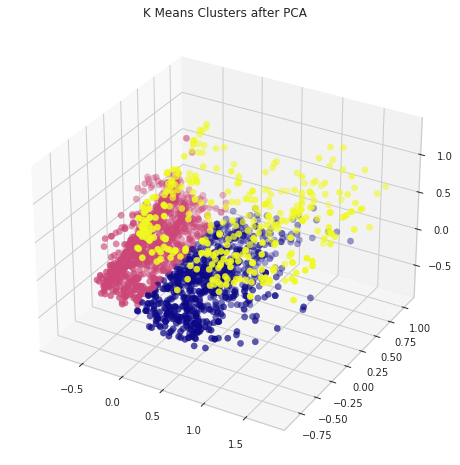

In [34]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x,y,z, s=40, c= km.labels_, marker='o' ,cmap = 'plasma' )
ax.set_title("K Means Clusters after PCA")
plt.show()

In [35]:
# Silhoutte Score
sc= silhouette_score(PCA_df, km.labels_)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.5524586155326089


This is significant improvement over the Silhoutte Score that we got when we implemented KMeans without PCA!

<a id= "tsne" > </a>

## t-SNE

Just like PCA, t-SNE takes high-dimensional data and reduces it to a low-dimensional graph (2-D typically). It is also a great dimensionality reduction technique. Unlike PCA, t-SNE can reduce dimensions with non-linear relationships.<br>
Please keep in mind t-SNE is a computationally heavy algorithm. Computational time can be reduced using the ‘n_iter’ parameter.

In [36]:
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=250, learning_rate=200)
tsne_scale_results = tsne.fit_transform(df_enc_scaled)
tsne_df = pd.DataFrame(tsne_scale_results, columns=['tsne1', 'tsne2', 'tsne3'])


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2216 samples in 0.000s...
[t-SNE] Computed neighbors for 2216 samples in 0.204s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2216
[t-SNE] Computed conditional probabilities for sample 2000 / 2216
[t-SNE] Computed conditional probabilities for sample 2216 / 2216
[t-SNE] Mean sigma: 0.346805
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.287537
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000


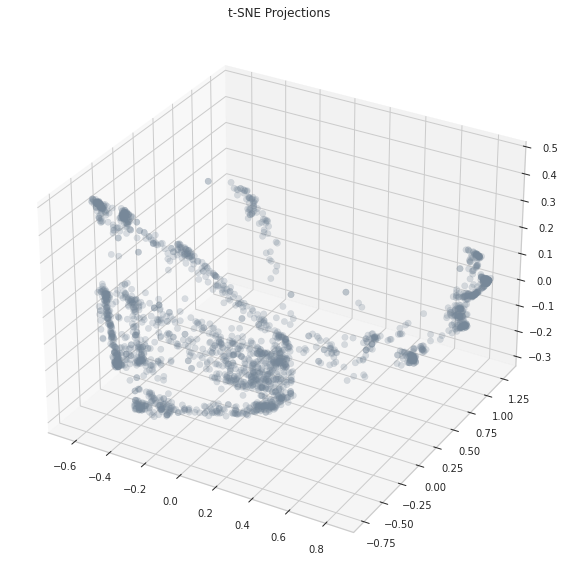

In [37]:
#Plot t-SNE projections on a 3D map
tx= tsne_df.iloc[:,0]
ty= tsne_df.iloc[:,1]
tz= tsne_df.iloc[:,2]
fig= plt.figure(figsize = (10,10))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(tx,ty,tz,s=40,alpha=0.25, facecolor='lightslategray',marker='o' ,cmap = 'plasma' )
ax.set_title("t-SNE Projections")
plt.show()

<a id= "ktsne" > </a>

## 1.3 KMeans Clustering after t-SNE

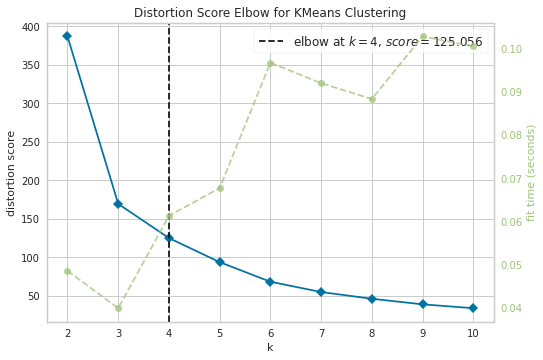

In [38]:
elbow_auto(tsne_df)

In [39]:
silhoutte(tsne_df,2,11)

 For 2 clusters, SilhoutteScore is: 0.6552996635437012
 For 3 clusters, SilhoutteScore is: 0.5828331112861633
 For 4 clusters, SilhoutteScore is: 0.5758150815963745
 For 5 clusters, SilhoutteScore is: 0.5677171945571899
 For 6 clusters, SilhoutteScore is: 0.5706655383110046
 For 7 clusters, SilhoutteScore is: 0.5328137874603271
 For 8 clusters, SilhoutteScore is: 0.5096473097801208
 For 9 clusters, SilhoutteScore is: 0.5060915946960449
 For 10 clusters, SilhoutteScore is: 0.5270903706550598


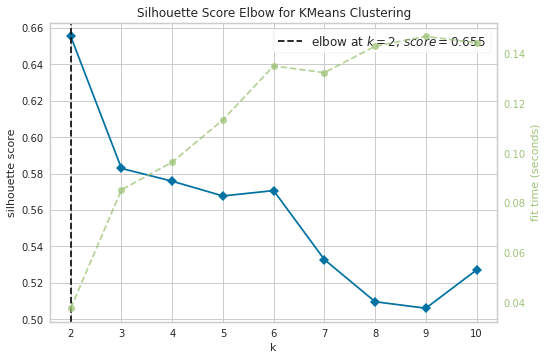

In [40]:
silhoutte_auto(tsne_df,2,11)

Once again, we will use 3 Clusters

In [41]:
km= KMeans(n_clusters=3, init='k-means++',
            n_init=10, max_iter=100, random_state=0)
ypred= km.fit_predict(tsne_df)
#Adding the Clusters feature to the orignal dataframe.
df["cluster_km_tsne"] = km.labels_


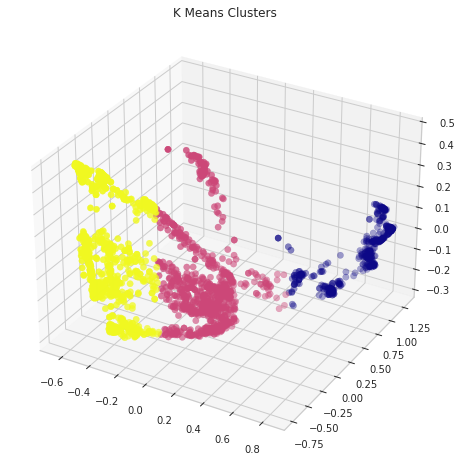

In [42]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(tx,ty,tz, s=40, c=km.labels_, marker='o' ,cmap = 'plasma' )
ax.set_title("K Means Clusters")
plt.show()

In [43]:
# Silhoutte Score
sc= silhouette_score(tsne_df, km.labels_)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.5828331112861633


So, we see that t-SNE KMeans clusters have the highest silhoutte score.

## Other Clustering Algorithms

Let us now explore some of the other popular clustering algorithms

<a id= "mini" > </a>

### 2. Mini-Batch K Means

The Mini-batch K-means clustering algorithm is a version of the K-means algorithm which can be used instead of the K-means algorithm when clustering on huge datasets because it does not iterate over the entire dataset. 
The algorithm takes small randomly chosen batches of the dataset for each iteration. Each data in the batch is assigned to the clusters, depending on the previous locations of the cluster centroids. It then updates the locations of cluster centroids based on the new points from the batch. The update is a gradient descent update, which is significantly faster than a normal Batch K-Means update.

A good paper to understand the difference between k-means and mini-batch KMeans: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://upcommons.upc.edu/bitstream/handle/2117/23414/R13-8.pdf

In [44]:
#Initiating the MiniBatchKMeans Clustering model 
MP = MiniBatchKMeans(n_clusters=3)
# fit model and predict clusters
MP_df = MP.fit_predict(tsne_df)
#Adding the Clusters feature to the orignal dataframe.
df["cluster_mini"]= MP_df

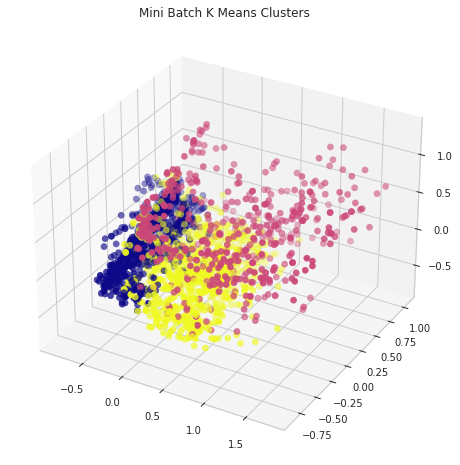

In [45]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=df["cluster_mini"], marker='o', cmap = 'plasma' )
ax.set_title("Mini Batch K Means Clusters")
plt.show()

In [46]:
# Silhoutte Score
sc= silhouette_score(tsne_df, MP_df)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.5828288793563843


<a id= "agglo" > </a>

### 3. Agglomerative Clustering

Agglomerative Clustering is a specific type of Hierarchical Clustering. The metric that it uses for merging clusters is the distance, ie. it merges the closest pair of clusters, based on the distance among centroids and repeats this step until only a single cluster is left. For this purpose, the proximity matrix is used. This matrix stores the distances between each point. The algorithm can be described as:
1. Every point is stored in its own cluster
2. The proximity Matrix is calculated
3. Closest points are detected and merged. They are the cluster and centroid is calculated.
4. The proximity matrix is updated using the centroid of the created cluster.
5. Steps 3 and 4 are repeated until one cluster is created.

This is a tree diagram that records all merges that happened during the training process. So, every time we merge two points or clusters, this is stored in the dendrogram. Here is how we can create it using SciPy:

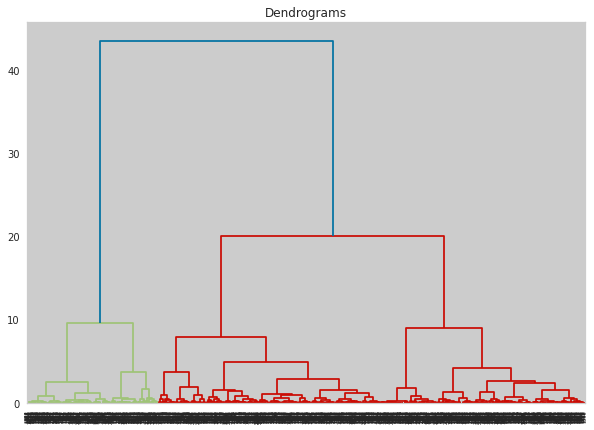

In [47]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = dendrogram(linkage(tsne_df, method='ward'))

What are we looking at? Well, on the x-axis we have all points in the dataset, while on the y-axis we have distances between those points. Every time points or clusters are merged this is represented with a horizontal line. The vertical line represents the distances between merged points/clusters. Longer vertical lines in the dendrogram indicate that the distance between clusters is bigger. In the next step, we need to set a threshold distance and draw a horizontal line in this image. In general, we try to set the threshold in such a way that it cuts the tallest vertical line. In our example, we set it to 15. Here is how that is done:

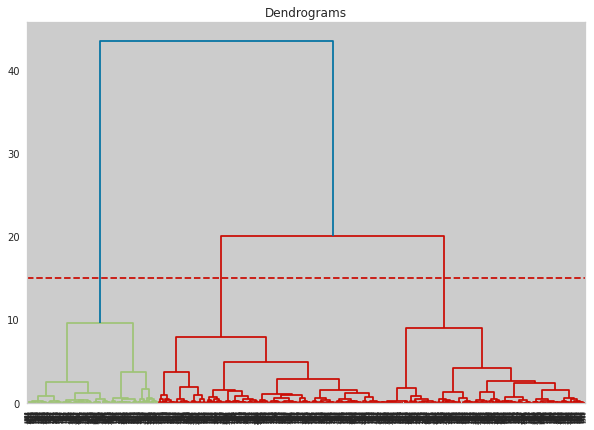

In [48]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = dendrogram(linkage(tsne_df, method='ward'))
plt.axhline(y=15, color='r', linestyle='--')

The number of clusters is determined by the number of vertical lines that are being intersected by the threshold line. As we can see the number of clusters in our example is 3.

**Using Scikit Learn**

In [49]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=3)
# fit model and predict clusters
yhat_AC = AC.fit_predict(tsne_df)
#Adding the Clusters feature to the orignal dataframe.
df["cluster_agglo"]= yhat_AC

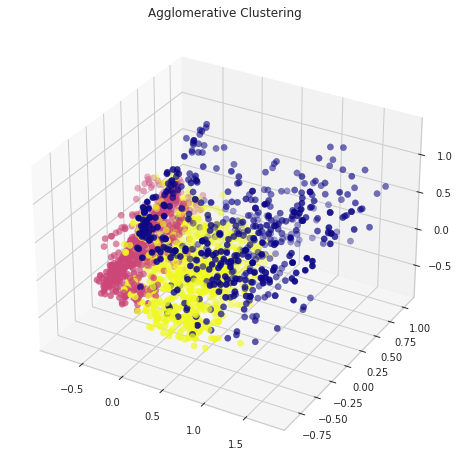

In [50]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c= yhat_AC, marker='o', cmap = 'plasma' )
ax.set_title("Agglomerative Clustering")
plt.show()

In [51]:
# Silhoutte Score
sc= silhouette_score(tsne_df, yhat_AC)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.562274694442749


<a id= "dbscan" > </a>

### 4. DBSCAN

DBSCAN Clustering (where DBSCAN is short for Density-Based Spatial Clustering of Applications with Noise) involves finding high-density areas in the domain and expanding those areas of the feature space around them as clusters.
It is implemented via the DBSCAN class and the main configuration to tune is the “eps” and “min_samples” hyperparameters.<br>
A good article on how to selet the hyperparameters: https://www.section.io/engineering-education/dbscan-clustering-in-python/

We define two hyperparameters for distance ε and the number of samples per cluster – n. The steps are:
1. First, we assign a random sample x to the first cluster.
2. We count how many samples have a distance from the sample x that is less or equal to ε. If the number of such samples is greater or equal to n, we add them in the cluster.
3. We observe each new member of the cluster and perform step 2 for them too, ie. we calculate the number of samples within the ε area of the sample and if that number is larger then n, we add them to the cluster. We repeat this process recursively until there are no more samples left to put in it.
4. Steps from 1 to 3 for a new random unclustered sample.
5. The process is repeated like this until all samples are either clustered or marked as outliers.

The main advantage of this approach is that clusters have different and random shapes. Centroid-based algorithms always create clusters that have the shape of a hypersphere. That is why DBSCAN can be specifically useful for some data. Of course, the main problem is choosing optimal values for ε and n. 

***Finding optimal hyperparameters***

In [52]:
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(tsne_df) # fitting the data to the object
distances,indices=nbrs.kneighbors(tsne_df) # finding the nearest neighbours

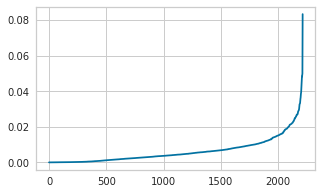

In [53]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

**Sklearn DBSCAN model**

In [54]:

#Initiating the DBSCAN Clustering model 
DB = DBSCAN(eps=0.4, min_samples=250, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
# fit model and predict clusters
DB_df = DB.fit_predict(tsne_df)
#Adding the Clusters feature to the orignal dataframe.
df["cluster_dbscan"]= DB_df


In [55]:
np.unique(DB_df)

array([0, 1])

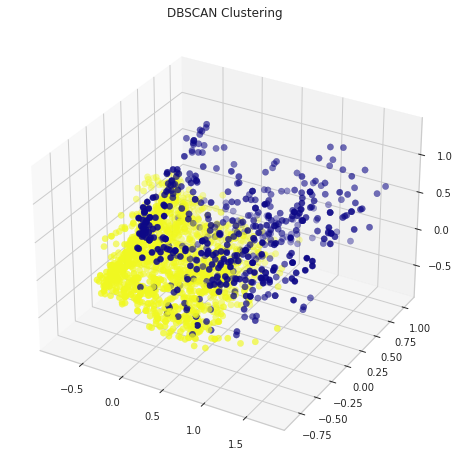

In [56]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c= DB_df, marker='o', cmap = 'plasma' )
ax.set_title("DBSCAN Clustering")
plt.show()

In [57]:
# Silhoutte Score
sc= silhouette_score(tsne_df, DB_df)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.6594724655151367


<a id= "optics" > </a>

### 5. OPTICS

OPTICS Clustering stands for Ordering Points To Identify Cluster Structure. It draws inspiration from the DBSCAN clustering algorithm. It adds two more terms to the concepts of DBSCAN clustering. They are:
- Core Distance: It is the minimum value of radius required to classify a given point as a core point. If the given point is not a Core point, then it’s Core Distance is undefined.
- Reachability Distance: It is defined with respect to another data point q(Let). The Reachability distance between a point p and q is the maximum of the Core Distance of p and the Euclidean Distance(or some other distance metric) between p and q. Note that The Reachability Distance is not defined if q is not a Core point.<br>
Source: https://www.geeksforgeeks.org/ml-optics-clustering-explanation/
- The OPTICS clustering approach consumes more memory since it uses a priority queue (Min Heap) to select the next data point in terms of Reachability Distance that is closest to the point presently being processed. It also needs greater computer resources since nearest neighbour queries in DBSCAN are more complex than radius queries.<br>
Source: https://analyticsindiamag.com/a-guide-to-clustering-with-optics-using-pyclustering/

In [58]:
#Initiating the OPTICS Clustering model 
OP = OPTICS(eps=0.4, min_samples=250)
# fit model and predict clusters
OP_df = OP.fit_predict(tsne_df)
#Adding the Clusters feature to the orignal dataframe.
df["cluster_optics"]= OP_df

In [59]:
np.unique(OP_df)

array([-1,  0,  1])

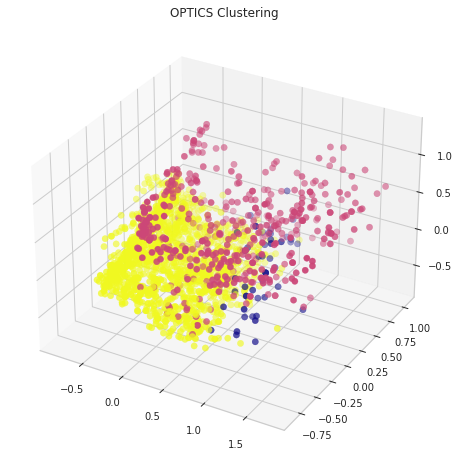

In [60]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c= OP_df, marker='o', cmap = 'plasma' )
ax.legend()
ax.set_title("OPTICS Clustering")
plt.show()

In [61]:
# Silhoutte Score
sc= silhouette_score(tsne_df, OP_df)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.4219544231891632


<a id= "birch" > </a>

### 6. BIRCH

Balanced Iterative Reducing and Clustering using Hierarchies (BIRCH) is a clustering algorithm that can cluster large datasets by first generating a small and compact summary of the large dataset that retains as much information as possible. This smaller summary is then clustered instead of clustering the larger dataset. BIRCH is often used to complement other clustering algorithms by creating a summary of the dataset that the other clustering algorithm can now use.

Parameters of BIRCH Algorithm :
- threshold :  threshold is the maximum number of data points a sub-cluster in the leaf node of the CF tree can hold.
- branching_factor : This parameter specifies the maximum number of CF sub-clusters in each node (internal node).
- n_clusters : The number of clusters to be returned after the entire BIRCH algorithm is complete i.e., number of clusters after the final clustering step. If set to None, the final clustering step is not performed and intermediate clusters are returned.

In [62]:

#Initiating the Birch Clustering model 
BP = Birch(threshold=0.5, n_clusters=3)
# fit model and predict clusters
BP_df = BP.fit_predict(tsne_df)
#Adding the Clusters feature to the orignal dataframe.
df["cluster_birch"]= BP_df


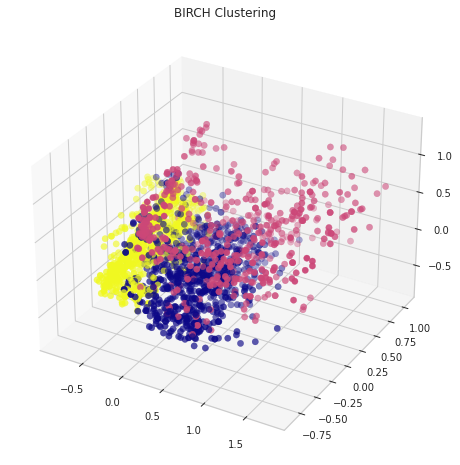

In [63]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c= BP_df, marker='o', cmap = 'plasma' )
ax.legend()
ax.set_title("BIRCH Clustering")
plt.show()

In [64]:
# Silhoutte Score
sc= silhouette_score(tsne_df, BP_df)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.5827950239181519


<a id= "eval" > </a>

## Evaluation of Clusters

Let us examine KMeans clusters that we generated after performing t-SNE on the data

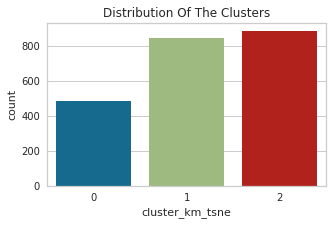

In [65]:
#Plotting countplot of clusters
pl = sns.countplot(x=df["cluster_km_tsne"])
pl.set_title("Distribution Of The Clusters")
plt.show()

To check the quality of each cluster we can examine the Silhuette plot.

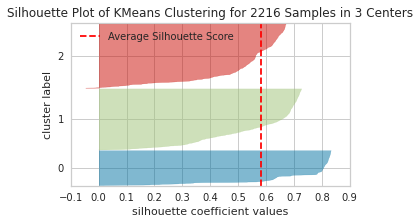

In [66]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=3, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(tsne_df)
visualizer.show()
plt.show()

In [67]:
df["Spent"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ \
df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

### Univariate Analysis

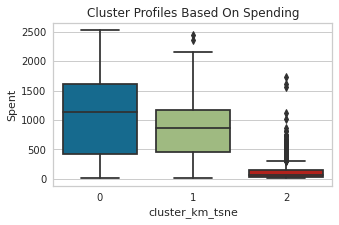

In [68]:
pl = sns.boxplot(data = df,x=df["cluster_km_tsne"],y=df["Spent"])
pl.set_title("Cluster Profiles Based On Spending")
plt.legend()
plt.show()

In [69]:
#Removing one outlier point on Income
df= df[df["Income"]<500000]

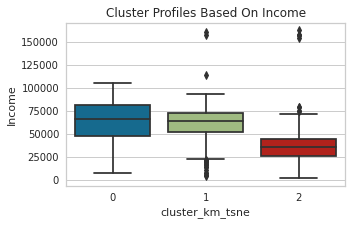

In [70]:
pl = sns.boxplot(data = df,x=df["cluster_km_tsne"],y=df["Income"])
pl.set_title("Cluster Profiles Based On Income")
plt.legend()
plt.show()

## Bivariate Analysis

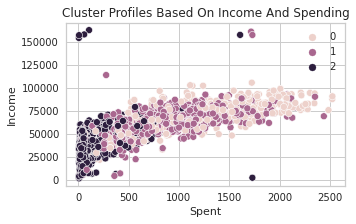

In [71]:
pl = sns.scatterplot(data = df,x=df["Spent"], y=df["Income"],hue=df["cluster_km_tsne"])
pl.set_title("Cluster Profiles Based On Income And Spending")
plt.legend()
plt.show()

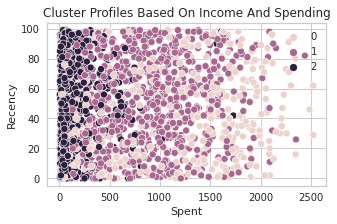

In [72]:
pl = sns.scatterplot(data = df,x=df["Spent"], y=df["Recency"],hue=df["cluster_km_tsne"])
pl.set_title("Cluster Profiles Based On Income And Spending")
plt.legend()
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning:

29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning:

60.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning:

85.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



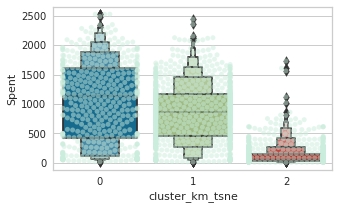

In [73]:
plt.figure()
pl=sns.swarmplot(x=df["cluster_km_tsne"], y=df["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=df["cluster_km_tsne"], y=df["Spent"])
plt.show()

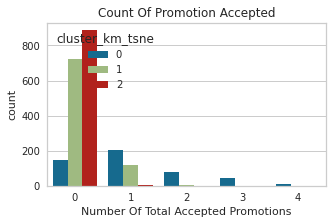

In [74]:
#Creating a feature to get a sum of accepted promotions 
df["Total_Promos"] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=df["Total_Promos"],hue=df["cluster_km_tsne"])
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

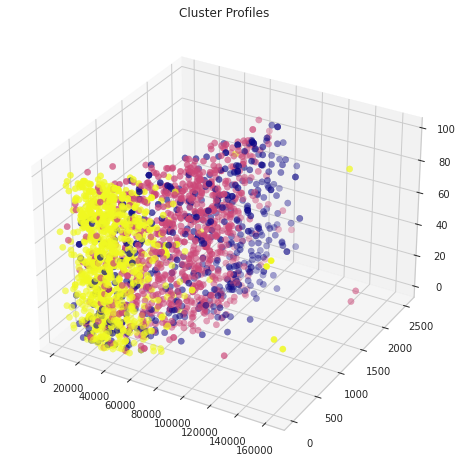

In [75]:
#3D Plot
x= df["Income"]
y= df["Spent"]
z= df["Recency"]
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c= df["cluster_km_tsne"], marker='o', cmap = 'plasma' )
ax.legend()
ax.set_title("Cluster Profiles")
plt.show()

Some more Clustering Methods to explore:
- Affinity Propagation
- Mean Shift Clustering
- Spectral Clustering

References: <br>
- https://www.kaggle.com/code/gaganmaahi224/9-clustering-techniques-for-customer-segmentation
- https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering/notebook
- https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap/data
- https://www.kaggle.com/code/azminetoushikwasi/clustering-different-techniques-algorithms/data
- https://rubikscode.net/2020/10/05/back-to-machine-learning-basics-clustering/
- https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6